In [85]:
from pathlib import Path
from smokingml.datasets.nursing_dataset_v1 import nursing_dataset_v1, nursingv1_train_dev_test_split, utils, WINSIZE
from smokingml.datasets.nursing_dataset_v1.dataloading import load_one_session
from smokingml.modules import evaluate_loop, train_loop, inner_evaluate_loop, inner_train_loop, optimization_loop
from smokingml.models import mlp_1hl, FCN, CNNModel
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch
import matplotlib.pyplot as plt
from smokingml.utils import plot_and_save_cm
from tqdm import tqdm

In [131]:
def window_session(session: torch.Tensor) -> torch.Tensor:
    # Window session
    x_acc = session[0].reshape(-1, 1)
    y_acc = session[1].reshape(-1, 1)
    z_acc = session[2].reshape(-1, 1)

    w = 5-1

    xs = [x_acc[:-w]]
    ys = [y_acc[:-w]]
    zs = [z_acc[:-w]]

    for i in range(1,w):
        xs.append(x_acc[i:i-w])
        ys.append(y_acc[i:i-w])
        zs.append(z_acc[i:i-w])

    xs.append(x_acc[w:])
    ys.append(y_acc[w:])
    zs.append(z_acc[w:])

    xs = torch.cat(xs,axis=1).float()
    ys = torch.cat(ys,axis=1).float()
    zs = torch.cat(zs,axis=1).float()

    # X = torch.cat([xs,ys,zs], axis=1)
    X = torch.cat([xs.unsqueeze(2), ys.unsqueeze(2), zs.unsqueeze(2)], axis=2)

    return X

In [134]:
guy = load_one_session(Path('../data/nursingv1_dataset'), 0)
X = guy[0]
X = torch.cat([torch.zeros(3, 5//2), X, torch.zeros(3, 5//2)], axis=1)
X = window_session(X)
y = torch.tensor(guy[1]).unsqueeze(1)
loader = DataLoader(TensorDataset(X,y), batch_size=64)

In [160]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=64)
        self.h1 = nn.Linear(in_features=64, out_features=10)
        self.h2 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        o,h = self.lstm(x)
        x = self.h1(o[:, -1, :])
        x = torch.relu(x)
        logits = self.h2(x)
        return logits

device = 'cuda:0'
model = LSTMModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

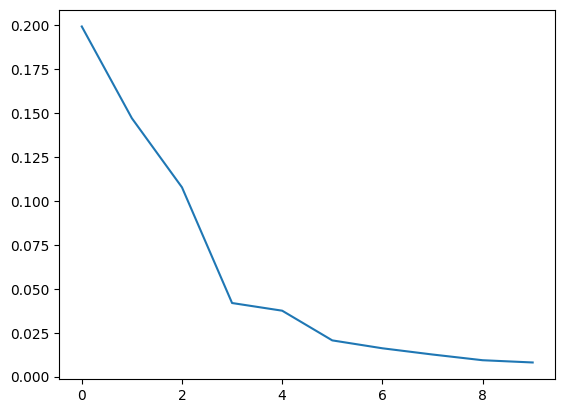

In [162]:
X = X.float()
y = y.float()


lossi = []

for i in range(10):
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lossi.append(loss.item())

    
plt.plot(lossi)
